**IB031 Project**

- [Source](https://www.kaggle.com/altruistdelhite04/loan-prediction-problem-dataset)

- [Testing csv](https://www.kaggle.com/altruistdelhite04/loan-prediction-problem-dataset/download/evL45lGV3RssadtbrRzN%2Fversions%2FvfUNmIbaXE87YsRW0vw8%2Ffiles%2Ftest_Y3wMUE5_7gLdaTN.csv?datasetVersionNumber=1)

- [Training csv](https://www.kaggle.com/altruistdelhite04/loan-prediction-problem-dataset/download/evL45lGV3RssadtbrRzN%2Fversions%2FvfUNmIbaXE87YsRW0vw8%2Ffiles%2Ftrain_u6lujuX_CVtuZ9i.csv?datasetVersionNumber=1)

In this project we will implement several models to predict credibility of a loan applicant. We will use the Loan Prediction Problem Dataset from Kaggle. The structure of the project is as follows:

1. Exploratory Analysis
2. Preprocessing of the dataset
3. Decision tree classifier
4. KNN classifier
5. Support Vector Machine
6. Deep Neural Network
7. Evaluation
8. Conclusion


## 1. Exploratory Analysis
The dataset consists of basic information about applicants. There are 13 columns with about 1000 rows. First of all, we will deal with the data types.

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sns.set()

Since pandas loads categorical data types as *'object'* dtype by default, we want to convert them back to category
after loading the csv. We are also dropping the "Loan_Status" column, which will later provide labels for classification. 
Unfortunately, this particular dataset does not contain a set of testing labels, therefore we were forced to split an
already sparse training set into 2 parts.

In [2]:
from sklearn.model_selection import train_test_split

#X_test = pd.read_csv("./test_Y3wMUE5_7gLdaTN.csv", index_col="Loan_ID")
dataset = pd.read_csv("./train_u6lujuX_CVtuZ9i.csv", index_col="Loan_ID")

for col in dataset.columns:
    if dataset[col].dtype == 'object':
        dataset[col] = dataset[col].astype('category')

X, y = dataset.drop(["Loan_Status"], axis=1), dataset["Loan_Status"][:]
y = y.map({"Y": True, "N": False})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [3]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 614 entries, LP001002 to LP002990
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Gender             601 non-null    category
 1   Married            611 non-null    category
 2   Dependents         599 non-null    category
 3   Education          614 non-null    category
 4   Self_Employed      582 non-null    category
 5   ApplicantIncome    614 non-null    int64   
 6   CoapplicantIncome  614 non-null    float64 
 7   LoanAmount         592 non-null    float64 
 8   Loan_Amount_Term   600 non-null    float64 
 9   Credit_History     564 non-null    float64 
 10  Property_Area      614 non-null    category
dtypes: category(6), float64(4), int64(1)
memory usage: 33.0+ KB


We have dropped the 'Loan_Status' column, which will provide labels during classification

In [4]:
X.shape

(614, 11)

In [5]:
y.shape

(614,)

The dataset had been split into training and testing subsets in around 1.67:1 ratio.

We can look at the amount of distinct values of selected features.

In [6]:
# value count of just some selected columns

print(X.Gender.value_counts()) # oh yeah boi
print(X.Married.value_counts())
print(X.Education.value_counts())
print(X.Property_Area.value_counts())

Male      489
Female    112
Name: Gender, dtype: int64
Yes    398
No     213
Name: Married, dtype: int64
Graduate        480
Not Graduate    134
Name: Education, dtype: int64
Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64


In [7]:
X.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
Loan_ID,,,,,,,,,,,
LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban
LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural
LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban
LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban
LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban


In [8]:
X.isnull().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
dtype: int64

As we can see, there are a lot of null values which will need to be imputed. Since there is no column with more missing data than present, we do not need to drop any.

In [9]:
X.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


Here we have some essential statistics about our dataset. For instance, we can see, that the most frequent length of loan term is about 1 year, with maximum being 1.5 year and minimum just 12 days. Furthermore, coapplicants have much lower income than applicants.

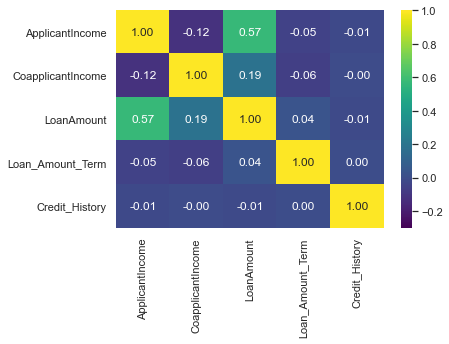

In [10]:
sns.heatmap(X.corr(), annot=True, vmin=-0.3, cmap="viridis", fmt=".2f")
plt.show()

We also computed and plotted correlation matrix of features in the dataset. There is only one pair of features, loan amount and applicant income, which can be considered to be mildly positively correlated. Other features, have nearly no correlation among them. This results is quite suprising, as one would expect higher correlation of features.

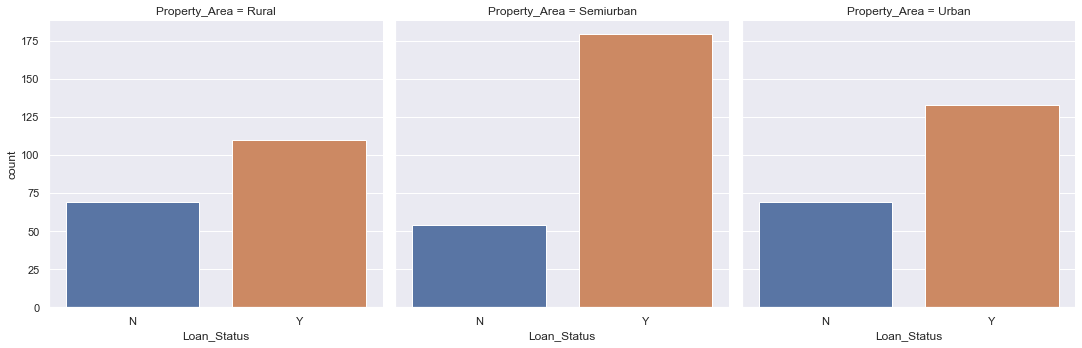

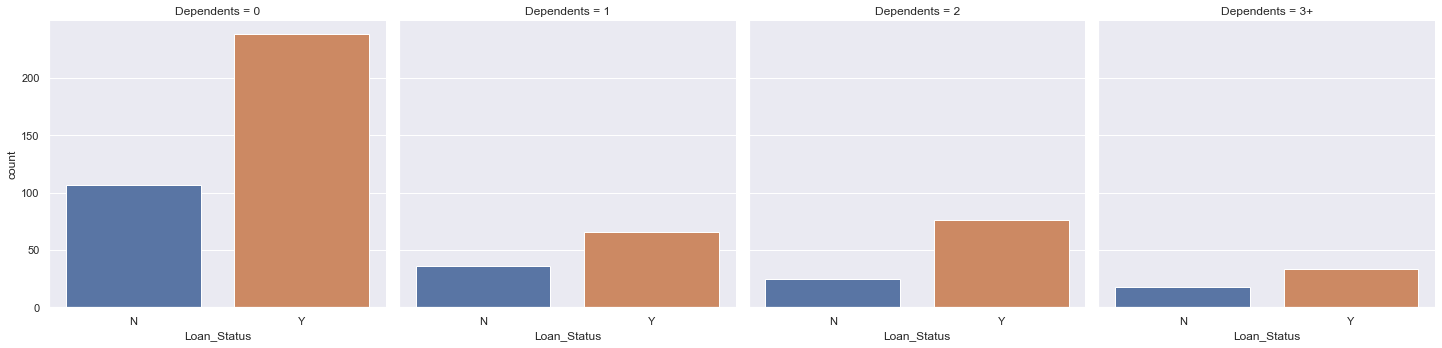

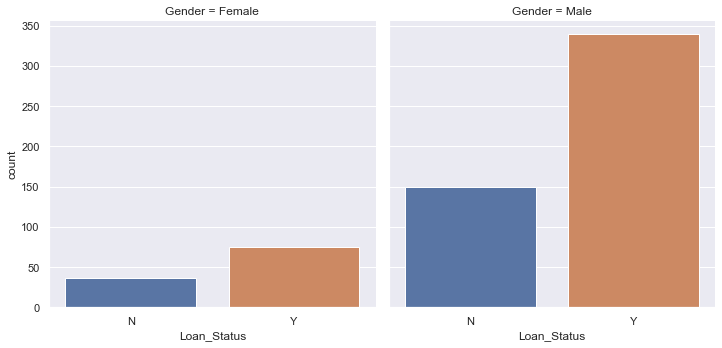

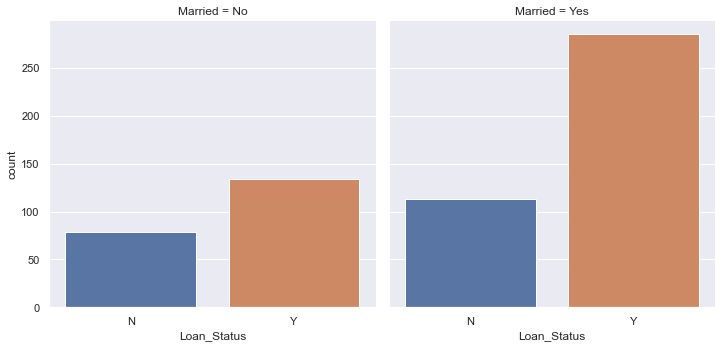

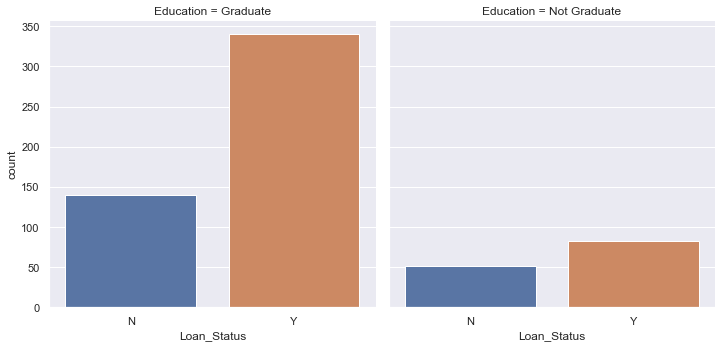

In [11]:
sns.catplot("Loan_Status", col="Property_Area", data=dataset, kind="count")
sns.catplot("Loan_Status", col="Dependents", data=dataset, kind="count")
sns.catplot("Loan_Status", col="Gender", data=dataset, kind="count")
sns.catplot("Loan_Status", col="Married", data=dataset, kind="count")
sns.catplot("Loan_Status", col="Education", data=dataset, kind="count")

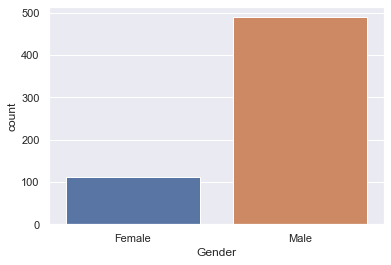

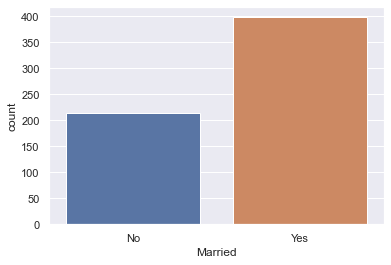

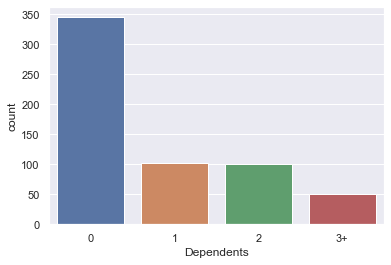

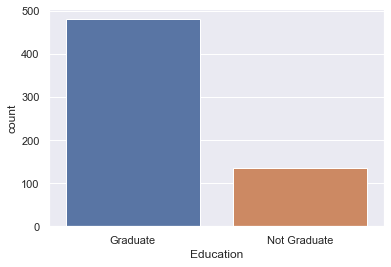

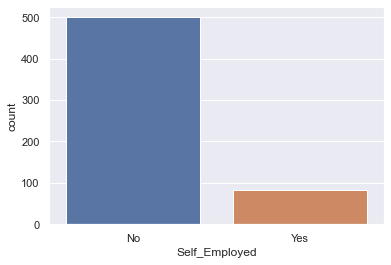

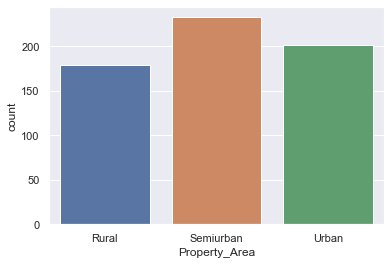

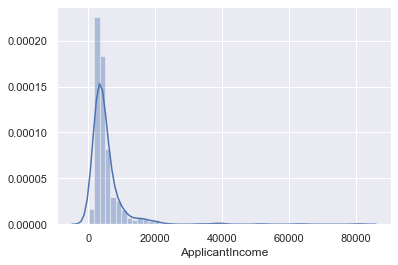

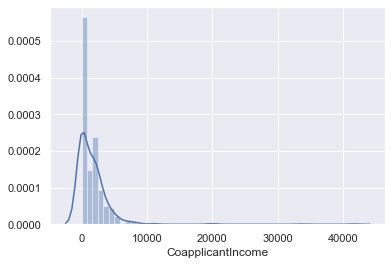

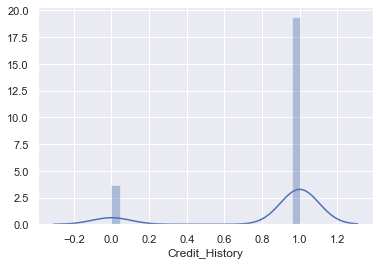

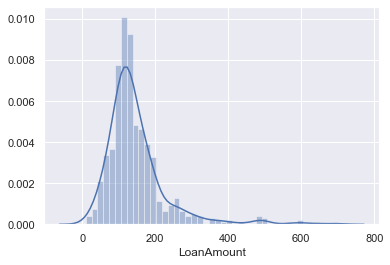

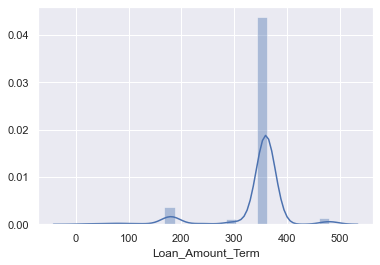

In [12]:
sns.countplot(X["Gender"])
plt.show()
sns.countplot(X["Married"])
plt.show()
sns.countplot(X["Dependents"])
plt.show()
sns.countplot(X["Education"])
plt.show()
sns.countplot(X["Self_Employed"])
plt.show()
sns.countplot(X["Property_Area"])
plt.show()
sns.distplot(X["ApplicantIncome"], kde=True)
plt.show()
sns.distplot(X["CoapplicantIncome"], kde=True)
plt.show()
sns.distplot(X["Credit_History"], kde=True)
plt.show()
sns.distplot(X["LoanAmount"], kde=True)
plt.show()
sns.distplot(X["Loan_Amount_Term"], kde=True)
plt.show()

Most of the features are scattered along the x-axis. The only exception is Loan Amount, which roughly follows the Chi-squared distribution.

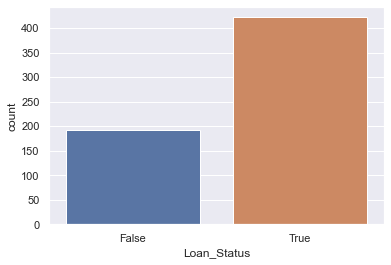

In [13]:
sns.countplot(y)

C:\Users\vojdo\Anaconda3\envs\ml\lib\site-packages\numpy\linalg\linalg.py:1965: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff


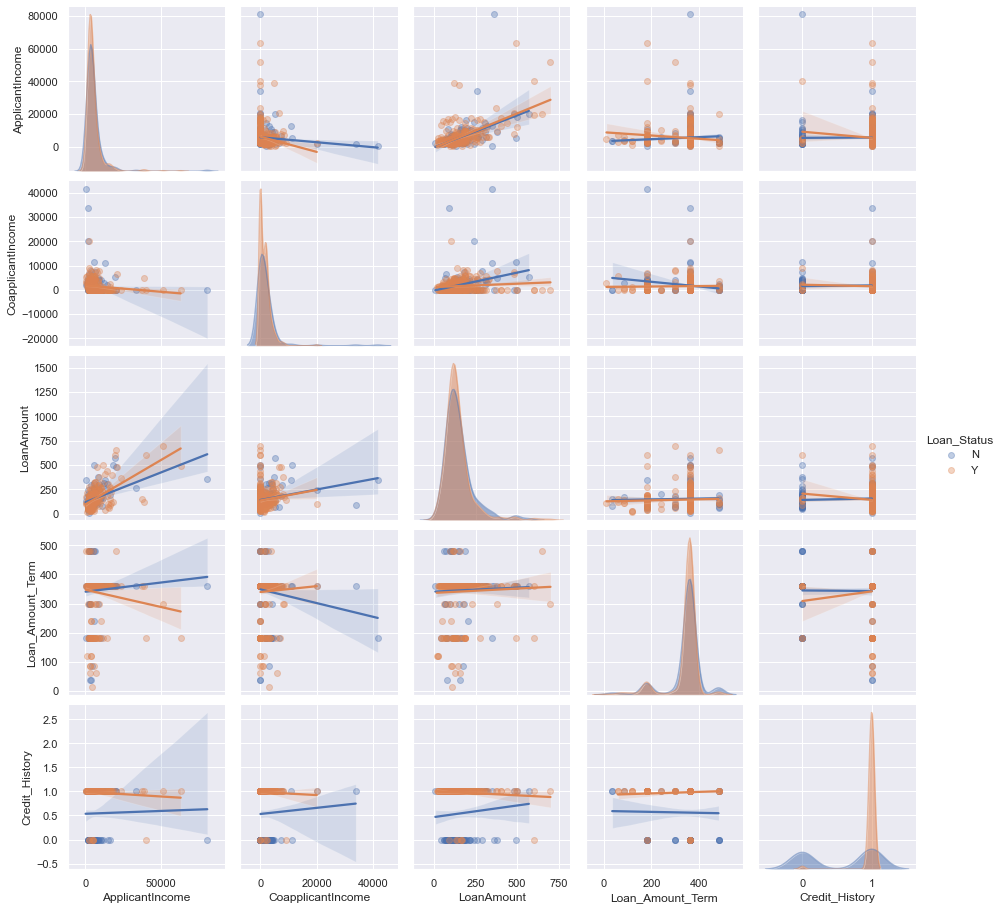

In [14]:
sns.pairplot(dataset, hue="Loan_Status", kind="reg", diag_kws={"alpha": 0.5}, plot_kws={"scatter_kws": {"alpha": 0.35}})

Credit history seems to have the highest impact on deciding whether the loan should be approved or not. Clients with low credit score seem more likely to be denied.

There are some cases where ApplicantIncome and CoapplicantIncome are very low, their loan request gets approved, whereas in a few cases the CoapplicantIncome is very high and ApplicantIncome is very low, the request gets denied.

## 2. Data preprocessing

In [15]:
y.isna().sum()

0

Good, there are no N/A labels. We do not need to drop any rows. Besides that, dropping a significant part of the dataset
could have misrepresenting effects.

Firstly, we will impute the missing values with ```SimpleImputer``` and strategy ```most_frequent```. As ```SimpleImputer```
returns an array, we will transform it back to a pandas dataframe. Another step
is encoding the categorical features using ```OneHotEncoder```. Lastly, we will scale the features with ```StandardScaler```. 
Their mean will therefore be 0 and variance 1.

The labels need significantly less preprocessing. Encoding their boolean values is sufficient.

In [16]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer

class NpToDf:
    columns = []

    def __init__(self, columns=None):
        self.columns = columns

    def fit(self, X, *args, **kwargs):
        return X

    def fit_transform(self, X, *args, **kwargs):
        return self.transform(X)

    def transform(self, X, *args, **kwargs):
        return pd.DataFrame(data=X, columns=self.columns)

pipe_X = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy="most_frequent"),
    NpToDf(X_train.columns),
    make_column_transformer(
        (OneHotEncoder(), ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area', 'Dependents']),
        remainder=StandardScaler()),
    NpToDf(),
)

pipe_y = make_pipeline(
    OrdinalEncoder()
)

In [17]:
pipe_X.fit_transform(X_train)
train_X = pipe_X.transform(X_train)
test_X = pipe_X.transform(X_test)

train_y = pipe_y.fit_transform(y_train.to_numpy().reshape(-1, 1)).reshape(-1)
test_y = pipe_y.fit_transform(y_test.to_numpy().reshape(-1, 1)).reshape(-1)

Some helper functions for training and evaluation of our models.

In [18]:
from sklearn.metrics import mean_squared_error, f1_score
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

def evaluate(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    scores = cross_val_score(clf, X_test, y_test, cv=10)

    print(f"RMSE: {mean_squared_error(y_test, y_pred, squared = False):.4f}")   
    print(f"Accuracy: {scores.mean():.3f} ± {scores.std() * 2:.3f}")
    print("F1 Score: %.2f" % f1_score(y_test, y_pred, average='weighted'))

In [19]:
from sklearn.metrics import plot_roc_curve

def roc(clf, test_X, test_y):
    plot_roc_curve(clf, test_X, test_y)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
    plt.legend()

In [20]:
from sklearn.metrics import plot_precision_recall_curve as prc
from sklearn.metrics import precision_recall_curve

In [21]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

def confusion(clf, X_test, y_test):
    plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues)    
                        

In [22]:
def get_gscv(clf, param_grid, verbose=1, **kwargs):
    gs = GridSearchCV(clf, param_grid, verbose=verbose, cv=kwargs.get("cv", 3), n_jobs=kwargs.get("workers", -2))
    gs.fit(train_X, train_y, **kwargs)
    score = gs.score(test_X, test_y)
    print(f"Best parameters: {gs.best_params_}, with F1 score of {score:.2f}")
    return gs.best_estimator_

In the following 4 sections, we will always start by running a grid search tuning hyperparameters of our models. There is a wrapper for keras sequential models, which
we will use for grid searching. All models will be trained on the same training set. We chose these evaluation metrics
- **RMSE** - measures error of the predictions compared to actual values, the lower the better. 
- **Acurracy** computed with cross validation score -  is the proportion of correct predictions (both true positives and true negatives) among the total number of cases examined, the higher the better
- **F1 score** - is weighted average of precision and recall, the best value is 1, the worst is 0
- **Receiver Operating Characteristic curve** -  measures the ability of a model to distinguish between classes
- **Precision Recall curve** - shows the tradeoff between precision and recall for different threshold
- **Confusion matrix** -  shows the number of True Positive (TP), False Negative (FN), True Negative (TN), False Positive (FP) classifications.

## 3. Decision tree classifier
Decision trees are among the most used classification models. They iteratively split the dataset, until a tree conforming to given parameters has been constructed. 
In leaves they contain class labels. Internal nodes represent kind of a boolean test, usually a value of a sample's feature, according to which the algorithm chooses the respective edge on the way to leaves.
The tests can also use entropy and information gain to choose the best edge. There are many to ways to construct a tree, therefore extensive hyperparameter tunning is suitable.
Decision trees can also be pruned, etheir during construction of after it. 

In [23]:
from sklearn.tree import DecisionTreeClassifier

dtree_clf = DecisionTreeClassifier()
dtree_values = {"criterion": ["gini", "entropy"],
                "max_depth": [1, 2, 5, 10, 16, None],
                "max_leaf_nodes": [6, 8, 10, 12, 20, None],
                "max_features": ["auto", "sqrt", "log2", 2, 4, 8]}
                
tree_clf = get_gscv(dtree_clf, dtree_values)

Fitting 3 folds for each of 432 candidates, totalling 1296 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done 185 tasks      | elapsed:    1.3s


Best parameters: {'criterion': 'gini', 'max_depth': 2, 'max_features': 'log2', 'max_leaf_nodes': 10}, with F1 score of 0.83


[Parallel(n_jobs=-2)]: Done 1296 out of 1296 | elapsed:    3.4s finished


RMSE: 0.4132
Accuracy: 0.772 ± 0.227
F1 Score: 0.81


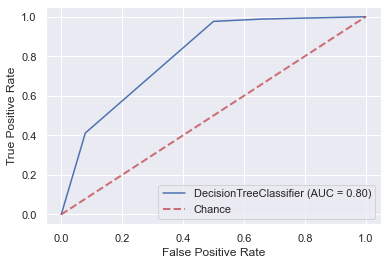

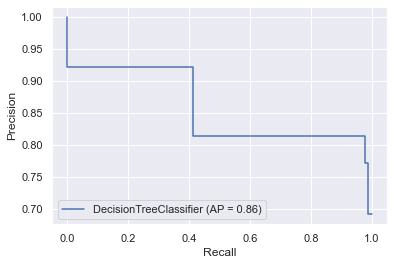

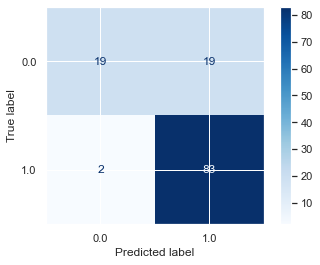

In [24]:
evaluate(tree_clf, test_X, test_y)
roc(tree_clf, test_X, test_y)
prc(tree_clf, test_X, test_y)
confusion(tree_clf, test_X, test_y)
plt.show()


## 4. KNN classifier

Another popular classification algorithm, an example of instace-based learning or lazy learning. This time, all distances from a data point to other points are computed, and k-closest neighbours are chosen. Then, the class memberships
of the _k-closest_ members are considered, with the original data point taking a class label from the most occuring one among its _k-closest_ neighbours. For the distance metrics,
_Euclidean_ or _Hamming_ distances are usually used. There is a tradeoff in the number of _k-closest_ neighbours. Smaller _k_, signifies the result of noise on classification, but makes
the various classses more distinct and vice versa with higher _k_. 

In [25]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_values = {"n_neighbors": list(range(2, 16, 2)), 
              "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
              "leaf_size": [10, 20, 30, 40, 50], 
              "p": [1, 2], 
              "weights": ["uniform", "distance"]}
              
knn_clf = get_gscv(knn_clf, knn_values)

Fitting 3 folds for each of 560 candidates, totalling 1680 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done 410 tasks      | elapsed:    1.3s


Best parameters: {'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 14, 'p': 2, 'weights': 'uniform'}, with F1 score of 0.85


[Parallel(n_jobs=-2)]: Done 1680 out of 1680 | elapsed:    4.8s finished


RMSE: 0.3930
Accuracy: 0.837 ± 0.165
F1 Score: 0.83


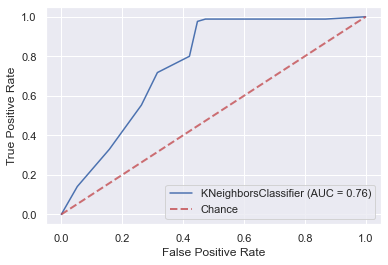

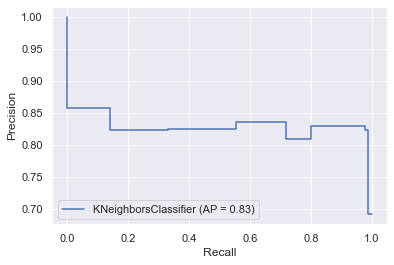

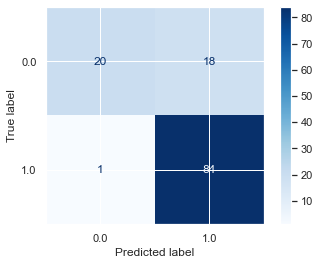

In [26]:
evaluate(knn_clf, test_X, test_y)
roc(knn_clf, test_X, test_y)
prc(knn_clf, test_X, test_y)
confusion(knn_clf, test_X, test_y)
plt.show()

## 5. Support Vector Machine

Support Vector Machines, abbr. SVM, is a supervised-learning algorithm used mainly for binary classification, although it is possible to use for multi-class classification
by combing several SVMs. It creates hyperplanes in a multi-dimensional feature space, which are then used for generalization and classifications of data points. The best
performing hyperplanes are those having  the biggest maximum margin, i.e. the closest data points from both classes are as far as possible. In order to transform input data
into a desired form, SVM uses so called kernel functions, which return the inner product between two points in a suitable feature space. 

In [27]:
from sklearn.svm import SVC

svc_clf = SVC()
svc_values = {"C": [.8, 1.0, 1.2, 1.5, 2.0],
              "kernel": ["linear","poly","rbf","sigmoid"],
              "degree": [2, 3, 4, 5], 
              "gamma": ["scale", "auto"], 
              "coef0": [.0, .5, 1.0, 1.5]}
              
svm_clf = get_gscv(svc_clf, svc_values)

Fitting 3 folds for each of 640 candidates, totalling 1920 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done 634 tasks      | elapsed:    1.6s


Best parameters: {'C': 0.8, 'coef0': 0.5, 'degree': 2, 'gamma': 'auto', 'kernel': 'sigmoid'}, with F1 score of 0.82


[Parallel(n_jobs=-2)]: Done 1920 out of 1920 | elapsed:    4.9s finished


RMSE: 0.4229
Accuracy: 0.829 ± 0.155
F1 Score: 0.80


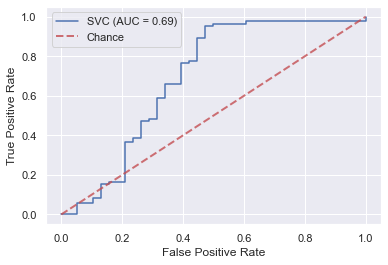

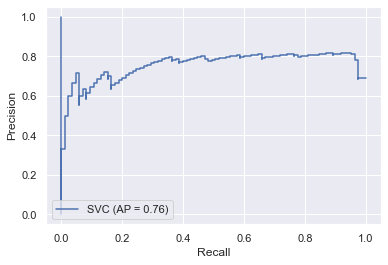

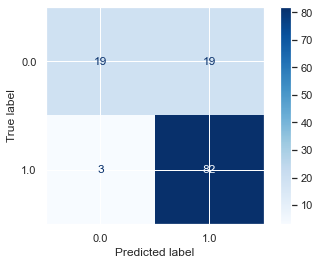

In [28]:
evaluate(svm_clf, test_X, test_y)
roc(svm_clf, test_X, test_y)
prc(svm_clf, test_X, test_y)
confusion(svm_clf, test_X, test_y)
plt.show()

## 6. Deep Neural Network
Deep neural networks (DNNs) are artifical neural (ANNs) networks with several hidden layers. Each layer is a fixed number of artificial
neurons, which accept an input, process it, and send it to the next layer. The layers are organized followingly: 


<div align="center"> input layer &rarr; hidden layers &rarr; output layer. </div>
<br />

Each layer has an activation function, whose choice greatly influences the overall performance. In classification tasks, the output layer
yields the final class labels. We will use `Sequential model` from `Keras` as our DNN. 

For the activation functions we will stick with ReLU or Recrified Linear Units. These are nearly linear functions commonly used in DNNs and provide the best results.
Leaky ReLU may be used as well.

We will be choosing either Adam, Stochastic Gradient Descent or RMSProp optimizer.

Batch size will remain constant 32 and epochs 10-15, since these numbers offer the best results for the time spent learning.

We have experimented with dropout a bit, but found little to no difference when using it, so it will be kept at 0

In [29]:
import tensorflow as tf
import itertools
import itertools
import gc

import keras.backend as K
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix
from keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


In [30]:
layer_sizes = [[[8, 16, 32, 64] for _ in range(size)] for size in range(6, 7)]
layer_combinations = list(itertools.chain.from_iterable(map(lambda sublist: list(itertools.product(*sublist)), layer_sizes)))
del layer_sizes

gc.collect()
gc.enable()

In [31]:
def build_net(optim, layers, lr, dropout, **kwargs):
    K.clear_session()
    model = Sequential()
    model.add(Dense(layers[0], input_shape=(train_X.shape[1],), activation='relu'))
    model.add(Dropout(dropout))
    for layer in layers[1:]:
        model.add(Dense(layer, activation='relu'))
        model.add(Dropout(dropout))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=optim(learning_rate=lr), metrics=['accuracy']) 
    return model

```python
net_clf = KerasClassifier(build_fn=build_net, verbose=0)

layer_sizes = [[[32, 64, 128] for _ in range(size)] for size in range(3, 5)]
layer_combinations = list(itertools.chain.from_iterable(map(lambda sublist: list(itertools.product(*sublist)), layer_sizes)))

net_values = {"optim": [Adam, SGD, RMSprop], "epochs": [10], "batch_size": [32], "layers": layer_combinations, "dropout": [.1], "lr": [4e-3, 1e-4]}

es = EarlyStopping(monitor='loss', min_delta=0, patience=2, verbose=0, mode='auto')

dnn_clf = get_gscv(net_clf, net_values, callbacks=[es])
```
Fitting 3 folds for each of 2880 candidates, totalling 8640 fits

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.

[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:   57.7s

[Parallel(n_jobs=-2)]: Done 194 tasks      | elapsed:  2.9min

[Parallel(n_jobs=-2)]: Done 444 tasks      | elapsed:  6.0min

[Parallel(n_jobs=-2)]: Done 794 tasks      | elapsed: 10.3min

[Parallel(n_jobs=-2)]: Done 1244 tasks      | elapsed: 16.2min

[Parallel(n_jobs=-2)]: Done 1794 tasks      | elapsed: 23.3min

[Parallel(n_jobs=-2)]: Done 2444 tasks      | elapsed: 32.8min

[Parallel(n_jobs=-2)]: Done 3194 tasks      | elapsed: 43.9min

[Parallel(n_jobs=-2)]: Done 4044 tasks      | elapsed: 55.9min

[Parallel(n_jobs=-2)]: Done 4994 tasks      | elapsed: 70.5min

[Parallel(n_jobs=-2)]: Done 6044 tasks      | elapsed: 88.4min

[Parallel(n_jobs=-2)]: Done 7194 tasks      | elapsed: 110.4min

[Parallel(n_jobs=-2)]: Done 8444 tasks      | elapsed: 133.1min

[Parallel(n_jobs=-2)]: Done 8640 out of 8640 | elapsed: 136.5min finished

##### 1. Best parameters: {'batch_size': 32, 'dropout': 0.1, 'epochs': 10, 'layers': (32, 64, 32, 64), 'lr': 0.004, 'optim': <class 'keras.optimizers.RMSprop'>}, with F1 score of 0.78
##### 2. Best parameters: {'batch_size': 32, 'dropout': 0.0, 'epochs': 15, 'layers': (8, 32, 8, 32), 'lr': 0.001, 'optim': <class 'keras.optimizers.RMSprop'>}, with F1 score of 0.77
##### 3. Best parameters: {'batch_size': 32, 'dropout': 0.1, 'epochs': 12, 'layers': (64, 64, 64, 64, 32, 16), 'lr': 0.0003, 'optim': <class 'keras.optimizers.Adam'>}, with F1 score of 0.85

In [32]:
ohe = OneHotEncoder()

nn_train_y = ohe.fit_transform(y_train.to_numpy().reshape(-1, 1))
nn_test_y = ohe.transform(y_test.to_numpy().reshape(-1, 1))

# best_args = {'batch_size': 32, 'dropout': 0.1, 'epochs': 15, 'layers': (32, 32, 8), 'lr': 0.0004, 'optim': RMSprop}
# best_args = {'batch_size': 32, 'dropout': 0.1, 'epochs': 12, 'layers': (64, 64, 64, 64, 32, 16), 'lr': 0.0003, 'optim': Adam}
# best_args = {'batch_size': 32, 'dropout': 0.0, 'epochs': 15, 'layers': (32, 32, 16, 8), 'lr': 0.0003, 'optim': Adam}
# best_args = {'batch_size': 32, 'dropout': 0.0, 'epochs': 12, 'layers': (64, 64, 64, 16, 32, 64), 'lr': 0.0003, 'optim': Adam}
best_args = {'batch_size': 32, 'dropout': 0.0, 'epochs': 20, 'layers': (256, 128, 64, 64, 32), 'lr': 0.0003, 'optim': Adam}

dnn_clf = KerasClassifier(build_fn=build_net, verbose=0, **best_args)

data = dnn_clf.fit(train_X, train_y, epochs=15, batch_size=32)
dnn_clf.model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               5376      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

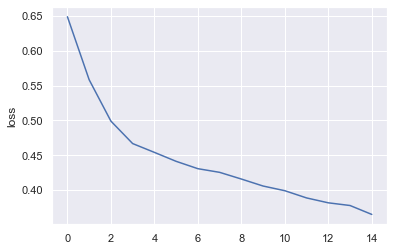

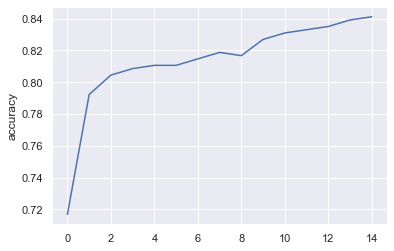

RMSE: 0.4229
Accuracy: 0.805 ± 0.102
F1 Score: 0.81


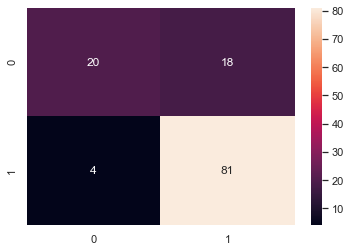


Classification Report
              precision    recall  f1-score   support

           Y       0.83      0.53      0.65        38
           N       0.82      0.95      0.88        85

    accuracy                           0.82       123
   macro avg       0.83      0.74      0.76       123
weighted avg       0.82      0.82      0.81       123



In [33]:
predicted_y = dnn_clf.predict(test_X)

history_df = pd.DataFrame(data=data.history, columns=data.history.keys())

sns.lineplot(legend='full', y='loss', x=range(len(data.history['loss'])), data=history_df)
plt.show()
sns.lineplot(legend='full', y='accuracy', x=range(len(data.history['accuracy'])), data=history_df)
plt.show()

true_y_labels = np.argmax(nn_test_y, axis=1) 

evaluate(dnn_clf, test_X, test_y)
sns.heatmap(confusion_matrix(true_y_labels, predicted_y), annot=True)
plt.show()

print('\nClassification Report')
target_names = ["Y", "N"]
print(classification_report(true_y_labels, predicted_y, target_names=target_names))

## 7. Evaluation
From evaluation metrics it seems, that _deep neural network_ wins the first prize. Its accuracy peaked at around 90%.
On the other side of the spectrum is _decision tree classifier_, which had the worst evaluation metrics from all models,
although _SVM_ was not far ahead. Surprisingly, _KNN_ had the second best performance, although it can be considered as the
most simple from all the used models. 

And finally, the winner's podium:

1. Deep Neural Network
2. KNN Classifier
3. Support Vector Machine
4. Decision Tree Classifier

Though keep in mind that with such small dataset the performance of all models may be influenced by the random state quite a bit.

The performance of all models could be improved by using weighted samples as the dataset is quite imbalanced.

The accuracy has quite a large differences between positive and negative samples. 
This is most likely caused by the fact that sampling for model training is not stratified whereas accuracy is computed using stratified cross validation.

All models seemed to have problems with recognising true negatives. In all cases the number of false negatives was greater than the number of true negatives.
Though this could be due to imbalanced dataset as well.

## 8. Conclusion
We have explored and preprocessed the dataset. From the computational side, training of the models and tuning of their hyperparameters did
not take too long, in average about 35sec per model, with neural network being an exception, as it was trained with several epochs for each
parameter search. Even though the dataset did not offer many records, we can conclude that the models performed overall quite well. 